In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import seaborn as sns
from sklearn.decomposition import PCA
sys.path.append('../')
from utils import *
from processing import *
import cv2 as cv
from image_registration import *

from skimage import color
import scipy as sp

import SimpleITK as sitk
from skimage.transform import rescale,resize
from pystackreg import StackReg
from PIL import Image

import ipywidgets as widgets
from ipywidgets import Box, IntSlider

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


No module named 'brainpy._c.composition'

          SPIKE
    Version     : 0.99.30
    Date        : 22-03-2022
    Revision Id : 563
*** zoom3D not loaded ***
plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin
plugins loaded:
FTMS_calib,  PhaseMS,  diagonal_2DMS, 


In [2]:
import pickle
with open('../processed_data/Coronal3D_UMAP_datainfo_decoded.pkl', 'rb') as fp:
    UMAP_datainfo = pickle.load(fp)
    
slice_order = ['slide1_2_R00','slide1_2_R01','slide1_2_R02','slide1_2_R03','slide1_2_R04','slide1_2_R05','slide1_2_R06',
              'slide1_2_R07','slide1_2_R08','slide3_5_R00','slide3_5_R10','slide3_5_R01','slide3_5_R02','slide3_5_R03',
              'slide3_5_R04','slide4_6_R00','slide4_6_R11','slide4_6_R01','slide4_6_R02','slide4_6_R03','slide4_6_R04',
              'slide3_5_R05','slide3_5_R06','slide3_5_R07','slide3_5_R08','slide3_5_R11','slide3_5_R09','slide4_6_R05',
              'slide4_6_R06','slide4_6_R07','slide4_6_R08','slide4_6_R09','slide4_6_R10','slide7_R00','slide7_R01',
              'slide7_R02','slide7_R03']
# no_transform = ['slide3_4_R01']
# rotate_slice = ['slide1_2_R13','slide1_2_R12','slide1_2_R11','slide1_2_R10','slide1_2_R09','slide1_2_R08','slide1_2_R05','slide1_2_R04','slide1_2_R03']

In [3]:
slice_order[9]

'slide3_5_R00'

In [4]:
import h5py
def pad(img, h, w):
    #  in case when you have odd number
    top_pad = np.floor((h - img.shape[0]) / 2).astype(int)
    bottom_pad = np.ceil((h - img.shape[0]) / 2).astype(int)
    right_pad = np.ceil((w - img.shape[1]) / 2).astype(int)
    left_pad = np.floor((w - img.shape[1]) / 2).astype(int)
    return np.copy(np.pad(img, [(top_pad, bottom_pad), (left_pad, right_pad)], mode='constant'))
idx = 0
umap_imgs = []
spec_idx_imgs = []
for slice in slice_order:
    data = UMAP_datainfo[slice_order[idx]]
    coord = data['coordinates']
    embedding = data['embeddings'][:,[1,7,8]]
    umap_img = color.rgb2gray(hyperspectral_vis(embedding,coord,True).transpose(1,0,2))
    umap_img = (umap_img - np.min(umap_img)) / (np.max(umap_img) - np.min(umap_img))
    spec_idx_img = IonImg(np.arange(1,embedding.shape[0]+1),coord,True,False)
    umap_img = pad(umap_img,512,512)
    spec_idx_img = pad(spec_idx_img,512,512)
    umap_imgs.append(umap_img)
    spec_idx_imgs.append(spec_idx_img)
    idx +=1

In [5]:
import nibabel as nib
file_dir = '../'
epi_labels = nib.load(file_dir+'WHS_SD_rat_atlas_v2.nii.gz')
epi_t2 = nib.load(file_dir+'WHS_SD_rat_T2star_v1.01.nii.gz')
epi_fa = nib.load(file_dir+'WHS_SD_rat_FA_color_v1.01.nii.gz')

epi_labels_data = epi_labels.get_fdata()
epi_t2_data = epi_t2.get_fdata()

In [6]:
mri_slice_num = [645,640,635,630,625,613,608,565,561,557,553,549,545,541,536,531,525,520,515,510,505,500,365,360,355,350,330,325,320,310,305,295,290,280,275,270,265]

mri_imgs = []
label_imgs = []
for i in range(len(mri_slice_num)):
    slice_no = mri_slice_num[i]

    label_slice = epi_labels_data[:, slice_no, :].copy()
    mri_slice = epi_t2_data[:, slice_no, :].copy()
    label_slice_mask = label_slice.copy()
    label_slice_mask[label_slice_mask>0] =1

    mri_slice_masked = mri_slice*label_slice_mask
    #mri_slice_masked = (mri_slice_masked - np.min(mri_slice_masked)) / (np.max(mri_slice_masked) - np.min(mri_slice_masked))
    mri_slice_masked = mri_slice_masked/mri_slice_masked.max()
    #mri_slice_masked[label_slice_mask==0]+=1
    mri_slice_masked = np.flip(mri_slice_masked.T)
    mri_slice_label = np.flip(label_slice.T)

    mri_imgs.append(mri_slice_masked)
    label_imgs.append(mri_slice_label)

In [7]:
from scipy.io import loadmat
spec_idx_transformed = loadmat('../image_register/Matlab Registration/coronal_registration/spec_idx_imgs_transformed.mat')['spec_idx_imgs_transformed']

In [8]:
slice_no = 9
region_idx = np.array(sorted(list(set(spec_idx_transformed[:,:,slice_no].T[np.isin(label_imgs[slice_no],[95,96,97,98])].astype(int)-1))))

In [11]:
from scipy.stats import rankdata
rankdata(hip_mask[hip_mask!=0],'dense')

array([1022, 1051, 1080, ..., 2519, 2575, 2575])

In [12]:
spec_idx_transform = spec_idx_transformed[:,:,slice_no].T.copy()
spec_idx_transform[~np.isin(label_imgs[slice_no],[95,96,97,98])] = 0
hip_mask = spec_idx_transform[100:200,130:410]
hip_mask[hip_mask!=0] = rankdata(hip_mask[hip_mask!=0],'dense')

In [13]:
len(list(set(hip_mask.flatten())))

4603

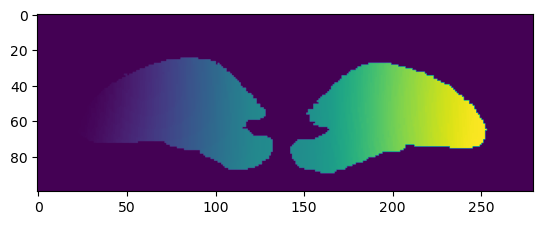

In [14]:
plt.imshow(hip_mask)

In [15]:
def load_data(file):
    with open(file, 'rb') as fp:
        data = pickle.load(fp)
        mz = data['mz']
        print(mz.shape)
        peak_data = data['peak_data']
        coord = []
        if 'coordinates' in data.keys():
            coord = data['coordinates']
    #intens_mtx = intens_mtx/tic.reshape(-1,1)
    return mz,peak_data,coord

slice_no = 9
input_dir = '/Volumes/Housecats2/3DCoronal/imzml/'
f_name = input_dir+'coronal3D_latent32_epoch10_{}_propagated_decoded.imzML'.format(slice_order[slice_no])
imzml_data = loadimzMLData(f_name)

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000491 found with incorrect name "line scan left right". Updating name to "linescan left right".
  warn(


TODO: convert indices into real world coordinates
loaded spectra
file loaded


In [406]:
intens_array, mz_bins_use, c = extractMZFeatures(imzml_data, ppm=3, mz_range=(400,1100), feature_n=0.2)

number of mass bins 101162


 17%|█████▉                            | 17619/101162 [00:04<00:19, 4294.59it/s]
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A Num

KeyboardInterrupt: 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [17]:
hip_data = intens_array[region_idx]
hip_data = pd.DataFrame(hip_data,columns=mz_bins_use)

In [18]:
sys.path.append('../scms_py')
from scMSData import scMSData
from analysis import scMSAnalysis

In [19]:
scms_decode = scMSData()
scms_decode.loadimzMLData('../peak_data_sc_hip_decode.imzML')

TODO: convert indices into real world coordinates
loaded spectra
file loaded


In [20]:
scms_decode.names = scms_decode.imzML_dataset.index_list

In [407]:
scms_decode.getIntensMtxData(ppm=3, feature_n=0.05, mz_range=(400,1100),mz_features=mz_bins_use)

number of mass bins 103


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 6634.52it/s]


In [22]:
tiss_data, mz_bins_use, c = extractMZFeatures(imzml_data, ppm=3, mz_range=(400,1100), feature_n=0.2,
                                              mz_bins=scms_decode.intens_mtx.columns)

number of mass bins 103


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 1375.70it/s]


In [23]:
tiss_data.shape

(44496, 103)

In [24]:
tiss_data = hip_data[mz_bins_use]

In [25]:
tiss_decode = scMSAnalysis()
tiss_decode.preprocessing(hip_data,norm_method='rms',feat_drop_rate=0.05,cell_drop_rate=0.05)

filtered intensity matrix with shape (4602, 3297)


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [26]:
sc_decode = scMSAnalysis()
sc_decode.preprocessing(scms_decode.intens_mtx,norm_method='rms',feat_drop_rate=0.05,cell_drop_rate=0.05)

filtered intensity matrix with shape (2692, 103)


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [27]:
tiss_decode.intens_mtx = tiss_decode.intens_mtx[sc_decode.intens_mtx.columns]

In [28]:
# idx = sc_decode.intens_mtx[(sc_decode.intens_mtx<0).sum(1)!=0].index
# sc_decode.intens_mtx = sc_decode.intens_mtx.drop(idx)
# sc_decode.metadata = sc_decode.metadata.drop(idx)
# sc_decode.adata.obs = sc_decode.adata.obs.drop(idx)

In [228]:
sc_decode.analyze(n_neighbors=30, n_pcs=30, min_dist=0.6, resolution = 0.2, categories=['leiden'])

computing neighbors..
performing umap...
performing clustering...


In [229]:
def show_cellEmbed(label, embed_method, size, rasterized=False,save=''):

    labels = sc_decode.adata.obs[label].values
    labels_unique = list(set(labels))
    labels_num = []

    for l in labels:
        labels_num.append(labels_unique.index(l))
    embedding = sc_decode.adata.obsm[embed_method]

    plt.close()
    fig, ax = plt.subplots(1, figsize=(5, 4),dpi=300)

    plt.scatter(embedding[:,0],embedding[:,1], s=size, c=labels_num, cmap='rainbow', alpha=1, rasterized=rasterized)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(len(labels_unique)+1)-0.5)
    cbar.set_ticks(np.arange(len(labels_unique)))
    cbar.set_ticklabels(labels_unique)

    if save !='':
        plt.savefig(save)
    plt.show()

In [230]:
show_embed = widgets.interactive(show_cellEmbed, label=sc_decode.adata.obs.columns,
                                 embed_method=sc_decode.adata.obsm.keys(),size=(0.05,1,0.1),save='');

In [231]:
show_embed

interactive(children=(Dropdown(description='label', options=('leiden',), value='leiden'), Dropdown(description…

In [76]:
plt.savefig('../figures/sc_decoded_umap_tiss_types.pdf')

<Figure size 432x288 with 0 Axes>

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:355: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


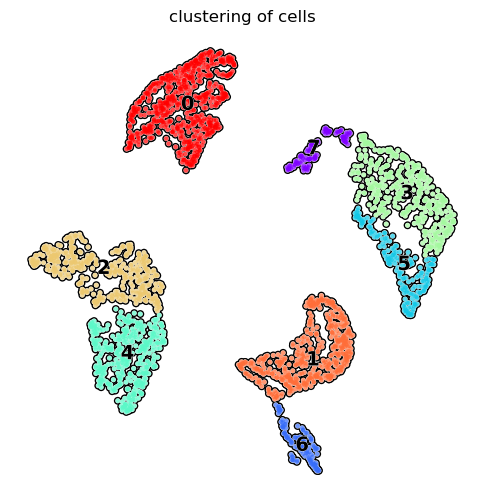

In [224]:
from matplotlib.pyplot import rc_context
import scanpy as sc
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.umap(sc_decode.adata, color='leiden', add_outline=True, legend_loc='on data',
               legend_fontsize=14, legend_fontoutline=0.5,frameon=False,
               title='clustering of cells', palette='rainbow_r',save='hip_cell_cluster.pdf')

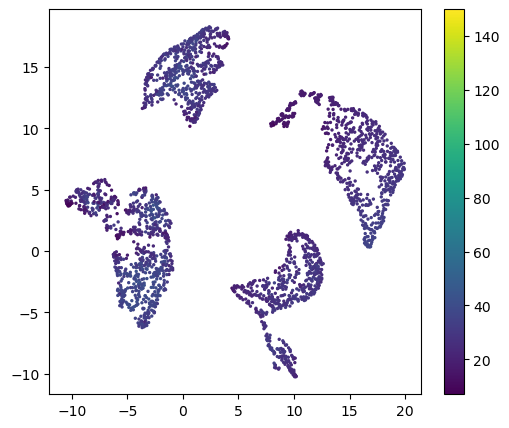

In [122]:
plt.figure(figsize=(6,5))
plt.scatter(sc_decode.adata.obsm['X_umap'][:,0],sc_decode.adata.obsm['X_umap'][:,1],
            c=sc_decode.intens_mtx.astype(bool).sum(1),s=2,vmax=150,rasterized=True)
plt.colorbar()
#plt.savefig('../figures/sc_decoded_umap_num_lipid.pdf',dpi=300)

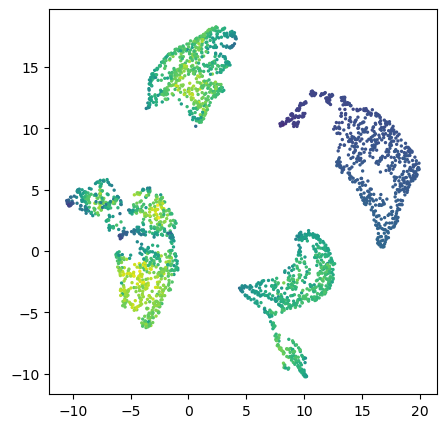

In [123]:
plt.figure(figsize=(5,5))
plt.scatter(sc_decode.adata.obsm['X_umap'][:,0],sc_decode.adata.obsm['X_umap'][:,1],
            c=sc_decode.intens_mtx.sum(1),s=2,vmin=0)

In [96]:
plt.savefig('../figures/sc_decoded_umap_tiss_leiden.pdf')

<Figure size 432x288 with 0 Axes>

In [225]:
sc_decode.get_labels(['leiden'])

In [239]:
label = 'leiden'
show_feat = widgets.interactive(sc_decode.show_featrank, label = label, region = sc_decode.label_class[label], 
                                rank_by=sc_decode.feat_rank[label].keys(), num_select=8000,
                                num_show=IntSlider(min=0, max=8000, step=20, value=0));

show_feat

interactive(children=(Text(value='leiden', description='label'), Dropdown(description='region', options=('0', …

In [639]:
show_feat.result['scores']

0      32.545994
1      22.873869
2      20.177328
3      20.123491
4      19.033451
         ...    
98    -12.444169
99    -13.280197
100   -13.784545
101   -14.434052
102   -14.759363
Name: scores, Length: 103, dtype: float32

Text(0, 0.5, '-log10(p-values)')

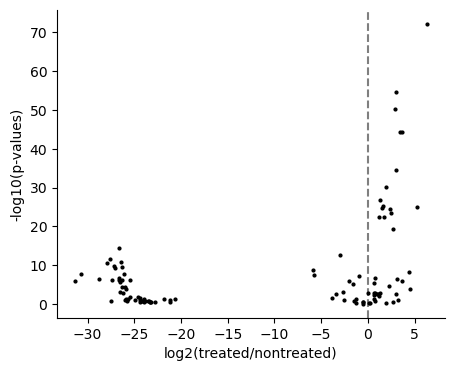

In [489]:
fig,axes = plt.subplots(1,1,figsize=(5,4))
axes.scatter(show_feat.result['logfoldchanges'],show_feat.result['pvals_adj'],s=4,c='k',edgecolors='k')
axes.axvline(0,linestyle='--',c='k',alpha=0.5)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.xlabel('log2(treated/nontreated)')
plt.ylabel('-log10(p-values)')
#plt.xlim([-4,3])
#plt.show()
#plt.savefig('../figures/volcano_sc_tha.pdf')

In [285]:
def show_featdist(features, embed_method, size, vmin=0):

    embedding = sc_decode.adata.obsm[embed_method]

    #plt.close()
    fig, ax = plt.subplots(1, figsize=(5, 4))

    plt.scatter(embedding[:,0],embedding[:,1], s=size, c=sc_decode.intens_mtx[features], cmap='Reds', alpha=1,vmin=vmin)
    plt.setp(ax, xticks=[], yticks=[])
    plt.colorbar()

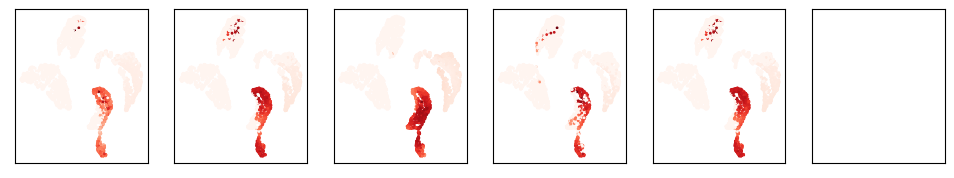

In [641]:
features_show = ['796.619','621.4834','608.2325','784.5659','621.4834']

fig, axes = plt.subplots(1,6, figsize=(12, 2))
ax = axes.ravel()
embedding = sc_decode.adata.obsm['X_umap']
for i,feature in enumerate(features_show):
    ax[i].scatter(embedding[:,0],embedding[:,1], s=1, c=sc_decode.intens_mtx[feature], cmap='Reds', alpha=1,vmin=0,rasterized=True)
    plt.setp(ax, xticks=[], yticks=[])
#plt.savefig('../figures/sc_umap_dist_top20.pdf',dpi=300)


categories: 0, 1, 2, etc.
var_group_labels: cortex


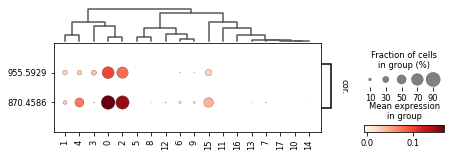

In [43]:
features_dict = {'cortex':['955.5929','870.4586']}
sc.pl.dotplot(sc_decode.adata, features_dict, 'leiden', dendrogram=True,swap_axes=True,figsize=(7,2),save='sc_cortex_specific_dot.pdf')


In [232]:
sc_decode.intens_mtx.columns[47]

'566.0302'

/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2406: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


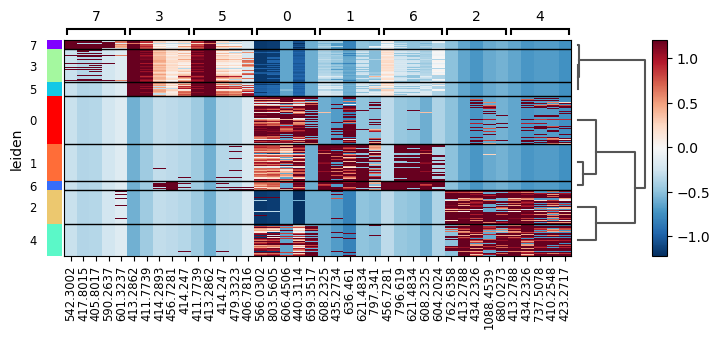

In [237]:
sc_decode.adata.layers['scaled'] = sc.pp.scale(sc_decode.adata, copy=True, zero_center=True).X
sc.pl.rank_genes_groups_heatmap(sc_decode.adata,n_genes=5,
              groupby='leiden',swap_axes=False,dendrogram=True,layer='scaled',cmap='RdBu_r',vmax=1.2,figsize=(8,3),save='hip_sc_regional_top10.pdf')


In [236]:
sc.tl.dendrogram(sc_decode.adata,groupby='leiden')

In [212]:
sc_decode.adata.write_h5ad('../processed_data/adata_hip_decoded_hip')

In [259]:
sc_decode.metadata

,leiden,leiden_int
0,3,3
1,5,5
2,3,3
3,7,7
4,7,7
...,...,...
2687,1,1
2688,3,3
2689,0,0
2690,5,5


In [51]:
mzs = np.load('../processed_data/coronal3d_mz.npy')
adducts = ['M+H','M+Na','M+K']
site_url = 'https://www.lipidmaps.org/rest/moverz/LIPIDS'

annot_df, matched, unmatched = LipidMaps_annotate([542.3002,417.8015,413.2862,479.3323,406.7816,456.7281]
, adducts, 3, site_url)

  0%|                                                     | 0/6 [00:00<?, ?it/s]../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
 17%|███████▌                                     | 1/6 [00:01<00:09,  1.97s/it]../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be 

In [49]:
annot_df

,Input m/z,Matched m/z,Delta,Name,Formula,Ion
0,542.3002,542.3007,0.0005,LPC O-18:3,C26H50NO6PK,[M+K]+
1,542.3002,542.3007,0.0005,LPE O-21:3,C26H50NO6PK,[M+K]+
2,413.2862,413.2874,0.0012,FA 21:0;O4,C21H42O6Na,[M+Na]+


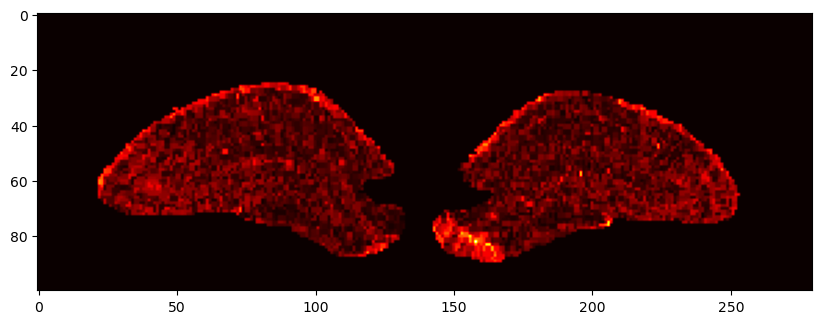

In [698]:
plt.figure(figsize=(10,5))
plt.imshow(reg.IonImg_transform(tiss_decode.intens_mtx['668.5699'],hip_mask,True),'hot',)

In [699]:
sc_decode.intens_mtx.columns[[47,  33,  70,  36,  58,  60,  62,  25,  46,  32,  95,  89,  88]].astype(float)
#['621.4834','784.5659','621.4834']

Float64Index([566.0302, 441.3297, 668.5699, 464.3126, 608.2325, 621.4834,
               636.461, 429.3491,  557.262, 440.3114, 871.5456, 803.5605,
               797.341],
             dtype='float64')

In [143]:
from sklearn.decomposition import TruncatedSVD, NMF

def get_sc_basis(data,labels,k):
    unique_labels = set(labels)
    labels = np.array(labels)
    basis = {}
    
    for label in unique_labels:
        d = data[labels==label]
        decom = TruncatedSVD(k)
        decom.fit(d)
        Vt = decom.components_
        basis[label] = Vt
    return basis

def get_sc_basis_nmf(data,labels,k):
    
    unique_labels = set(labels)
    labels = np.array(labels)
    basis = {}
    print(unique_labels)
    for label in unique_labels:
        d = data[labels==label]
        decom = NMF(k,max_iter=3000)
        decom.fit(d)
        Vt = decom.components_
        basis[label] = Vt
        print(label)
    return basis

In [144]:
idx = sc_decode.intens_mtx[(sc_decode.intens_mtx<0).sum(1)==0].index
#sc_basis = get_sc_basis(sc_decode.intens_mtx,list(sc_decode.metadata['leiden']),20)
sc_basis_nmf = get_sc_basis_nmf(sc_decode.intens_mtx.loc[idx],list(sc_decode.metadata.loc[idx]['leiden']),20)

{'1', '3', '5', '6', '7', '0', '2', '4'}
1


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


3


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


5


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


6


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


7


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


0


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


2
4


/Users/richard/anaconda/envs/scms/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 3000 reached. Increase it to improve convergence.
  warnings.warn(


In [424]:
clusters = ['0','1','2','3','4','5','6','7']
basis_values = []
for i in range(len(clusters)):
    basis_values.append(sc_basis_nmf[clusters[i]])
basis_values = np.concatenate(basis_values)

In [425]:
basis_values = basis_values/basis_values.max(0)
basis_values = basis_values/basis_values.max(1).reshape(-1,1)

(-0.2, 8.0)

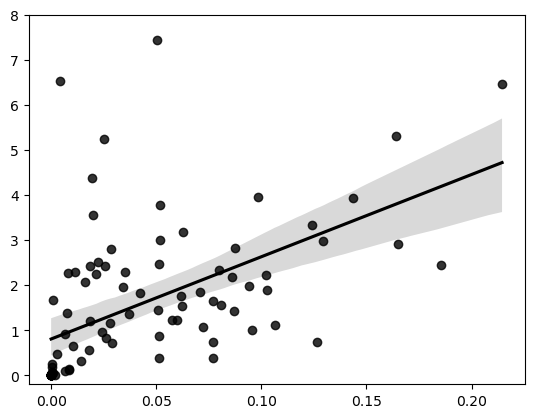

In [426]:
treated_data = sc_decode.intens_mtx.iloc[sc_decode.metadata['leiden'].values=='0'].values
nontreated_data = sc_decode.intens_mtx.iloc[sc_decode.metadata['leiden'].values!='0'].values
treated_mean = treated_data.mean(0)
nontreated_mean = nontreated_data.mean(0)
log2fold = (treated_mean/nontreated_mean)

sns.regplot(basis_values[0:20].mean(0),log2fold,color='k')
plt.ylim([-0.2,8])
#plt.savefig('../figures/basis_val_foldchange_cluster0.pdf')

In [420]:
pearsonr(basis_values[0:20].mean(0),log2fold)

(0.455894925011829, 1.3033560736137411e-06)

In [421]:
clusters

['0', '1', '2', '3', '4', '5', '6', '7']

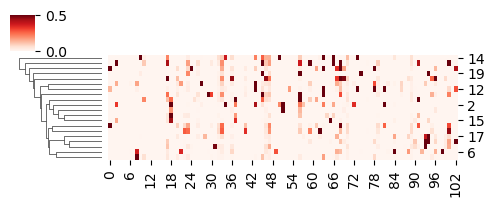

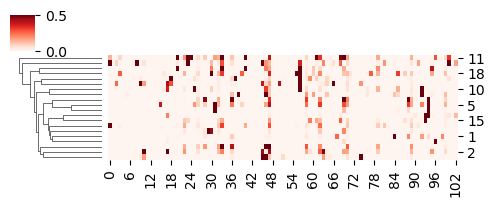

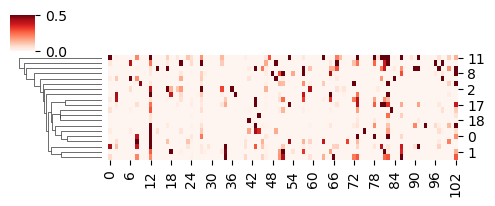

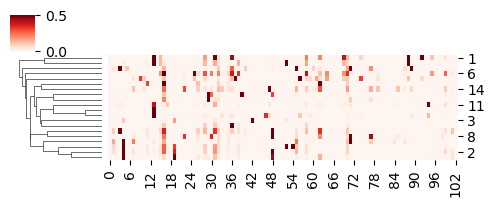

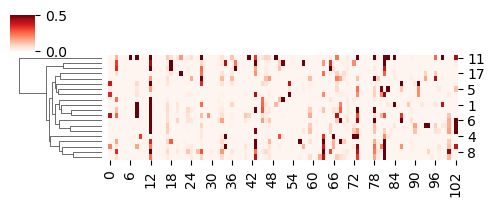

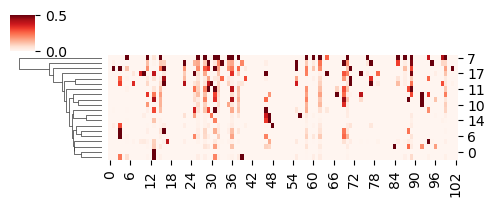

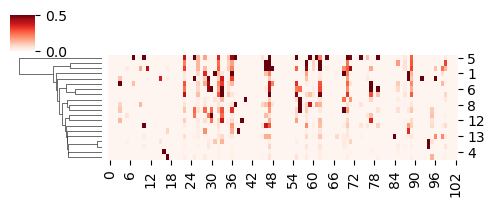

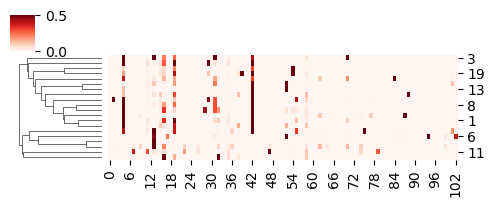

In [422]:
for i,cluster in enumerate(clusters):
    sns.clustermap(basis_values[20*i:20*i+20],cmap='Reds',col_cluster=False,figsize=(5,2),vmax=0.5)
    plt.savefig('../figures/hip_sc_basis_cluster_{}.pdf'.format(i))

In [149]:
from sklearn.linear_model import LinearRegression

def fit_tiss_sc_basis(data, basis, positive):
    label_names = list(basis.keys())
    basis = np.concatenate(list(basis.values()))
    
    coef = []
    
    for i in tqdm(range(0,data.shape[0],128)):
        reg = LinearRegression(positive=positive,n_jobs=8)
        reg.fit(basis.T, data[i:i+128].T)
        coef.append(reg.coef_)
        
    return np.concatenate(coef),label_names

def get_residual(data, basis, coef):
    return data - np.matmul(coef,np.concatenate(list(basis.values())))

In [150]:
np.concatenate(list(sc_basis_nmf.values())).shape

(160, 103)

In [387]:
coef,_ = fit_tiss_sc_basis(tiss_decode.intens_mtx.values, sc_basis_nmf, True)

100%|███████████████████████████████████████████| 36/36 [00:02<00:00, 13.96it/s]


In [388]:
residual = get_residual(tiss_decode.intens_mtx.values, sc_basis_nmf, coef[0])

In [389]:
res = tiss_decode.intens_mtx.values-np.matmul(coef,np.concatenate(list(sc_basis_nmf.values())))

In [390]:
basis_labels = []
for i in sc_basis_nmf.keys():
    basis_labels+=5*[i]

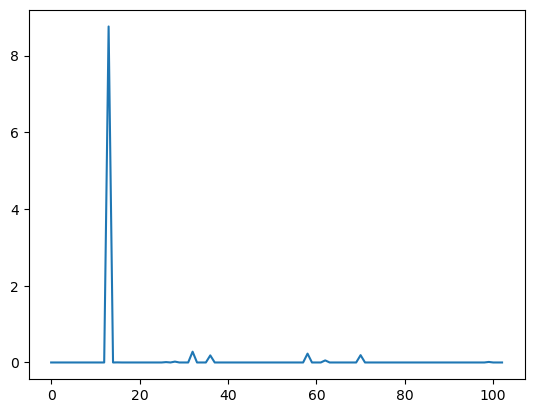

In [391]:
plt.plot(sc_basis_nmf['5'][0])

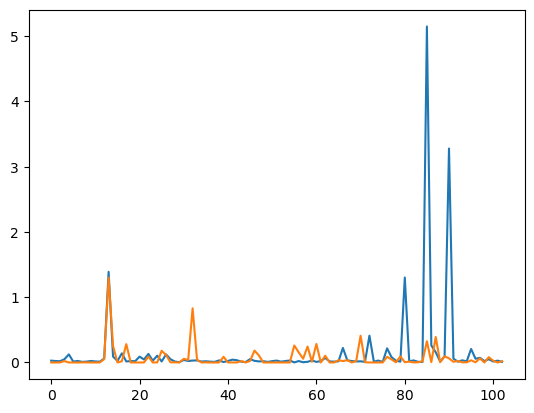

In [405]:
plt.plot(tiss_decode.intens_mtx.values[11])
plt.plot(np.matmul(coef,np.concatenate(list(sc_basis_nmf.values())))[11])

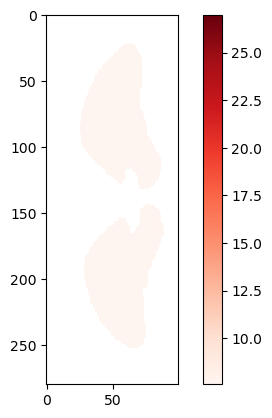

In [393]:
plt.figure()
img = reg.IonImg_transform(np.linalg.norm(residual,axis=1),hip_mask, False).T
plt.imshow(img,cmap='Reds',vmin=27)
plt.colorbar()

In [64]:
import image_registration
#file_dir = '../processed_data/coronal3D_propagated_decoded.h5'
file_dir = '/Volumes/Housecats2/3DCoronal/decoded_data_new/coronal3D_propagated_decoded_new.h5'
reg = image_registration.Image(data_dir=file_dir,registration_dir='../image_transform',group_order=slice_order)
reg.load_transform('../image_register/Matlab Registration/coronal_registration')

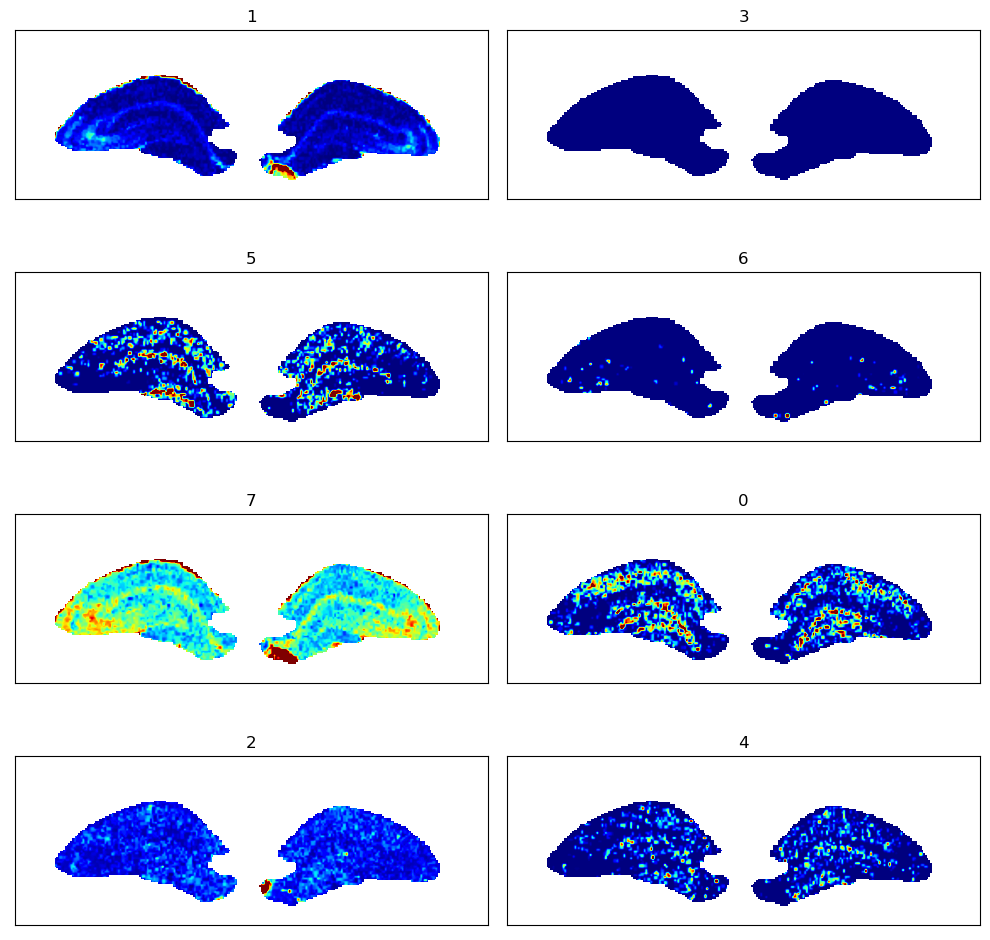

In [394]:
fig,axes = plt.subplots(4,2,figsize=(10,10))
ax = axes.ravel()
idx = 0
for i in range(0,coef.shape[1],20):
    img = reg.IonImg_transform(np.linalg.norm(coef[:,i:i+20],axis=1),hip_mask, False)
    ax[idx].imshow(img,cmap='jet',vmax=0.5*np.linalg.norm(coef[:,i:i+20],axis=1).max(),interpolation='gaussian')
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title(list(sc_basis_nmf.keys())[idx])
    idx += 1
fig.tight_layout()
#fig.savefig('../figures/hip_coef_cluster.pdf',dpi=300)

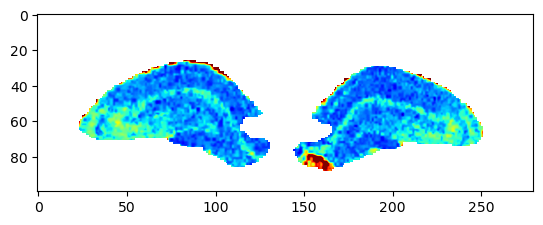

In [197]:
img = reg.IonImg_transform(np.linalg.norm(coef[:,80:100],axis=1),hip_mask, False)
plt.imshow(img,cmap='jet',vmax=0.7*np.linalg.norm(coef[:,80:100],axis=1).max(),interpolation='quadric')
plt.savefig('../figures/coef_cluster7.pdf',dpi=300)

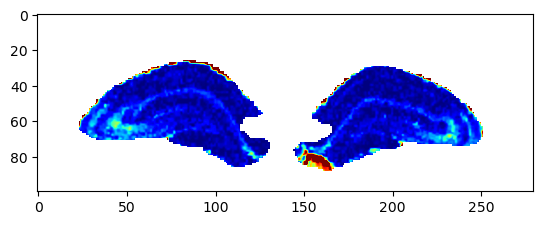

In [323]:
img = reg.IonImg_transform(np.linalg.norm(coef[:,0:20],axis=1),hip_mask, False)
plt.imshow(img,cmap='jet',vmax=0.4*np.linalg.norm(coef[:,0:20],axis=1).max(),interpolation='quadric')
plt.savefig('../figures/coef_cluster1.pdf',dpi=300)

TypeError: '>' not supported between instances of 'tuple' and 'float'

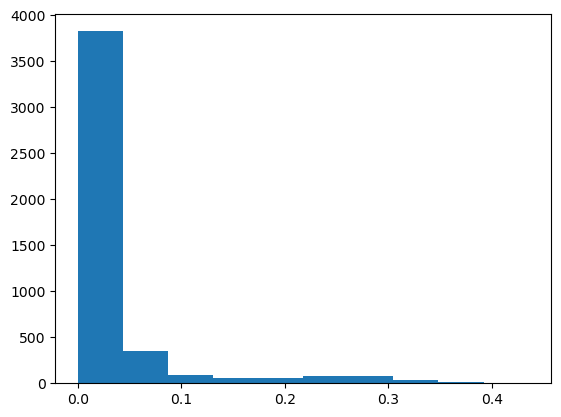

In [544]:
plt.hist(np.linalg.norm(coef[:,0:20],axis=1))>0.2

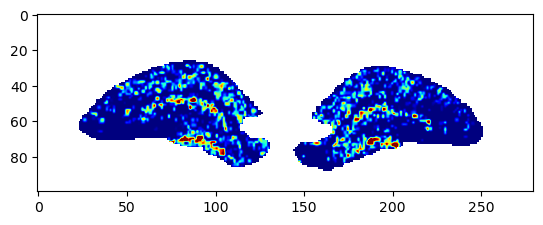

In [324]:
img = reg.IonImg_transform(np.linalg.norm(coef[:,40:60],axis=1),hip_mask, False)
plt.imshow(img,cmap='jet',vmax=0.6*np.linalg.norm(coef[:,40:60],axis=1).max(),interpolation='quadric')
plt.savefig('../figures/coef_cluster5.pdf',dpi=300)

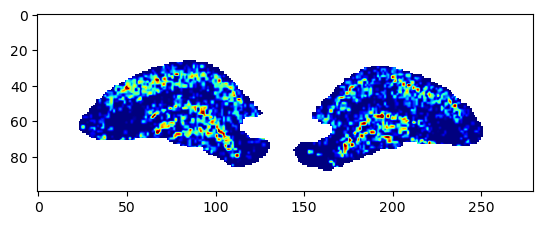

In [200]:
img = reg.IonImg_transform(np.linalg.norm(coef[:,100:120],axis=1),hip_mask, False)
plt.imshow(img,cmap='jet',vmax=0.6*np.linalg.norm(coef[:,100:120],axis=1).max(),interpolation='quadric')
plt.savefig('../figures/coef_cluster0.pdf',dpi=300)

In [531]:
np.linalg.norm(coef[:,40:60],axis=1).max()

9.486409848380757e-05

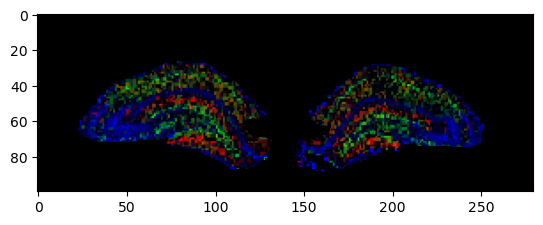

In [557]:
img1 = reg.IonImg_transform(np.linalg.norm(coef[:,40:60],axis=1),hip_mask, False)
img2 = reg.IonImg_transform(np.linalg.norm(coef[:,100:120],axis=1),hip_mask, False)
c = np.linalg.norm(coef[:,0:20],axis=1)
c[c>0.1] = 0
img3 = reg.IonImg_transform(c,hip_mask, False)

img1 = img1/np.linalg.norm(coef[:,40:60],axis=1).max()
img2 = img2/np.linalg.norm(coef[:,100:120],axis=1).max()
img3 = img3/c.max()
img = np.zeros((img1.shape[0],img1.shape[1],3))
img[:,:,0] = img1
img[:,:,1] = img2
img[:,:,2] = img3
plt.imshow(img)
plt.savefig('../figures/coef_cluster_composite.pdf',dpi=300)

In [522]:
from scipy.stats import pearsonr
pearsonr(np.linalg.norm(coef[:,180:200],axis=1),
            np.linalg.norm(coef[:,140:160],axis=1))

(-0.3476938089006444, 6.713433160835905e-131)

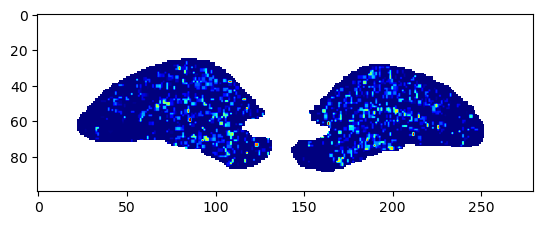

In [164]:
img = reg.IonImg_transform(np.linalg.norm(coef[:,140:160],axis=1),hip_mask, False)
plt.imshow(img,cmap='jet',vmax=0.8*np.linalg.norm(coef[:,140:160],axis=1).max())
#plt.savefig('../figures/coef_cluster13.pdf',dpi=300)

In [524]:
_.index('1')

2

In [206]:
CORR = []
clusters = [0,4,5,2,6,7,1]
from scipy.stats import pearsonr
for i in clusters:
    idx = _.index(str(i))
    coef1 = coef[:,20*idx:20*idx+20]
    corr = []
    for j in clusters:
        idx2 = _.index(str(j))
        coef2 = coef[:,20*idx2:20*idx2+20]
        p = pearsonr(np.linalg.norm(coef1,axis=1),np.linalg.norm(coef2,axis=1))[0]
        if np.isnan(p):
            corr.append(0)
        else:
            corr.append(p)

    CORR.append(corr)

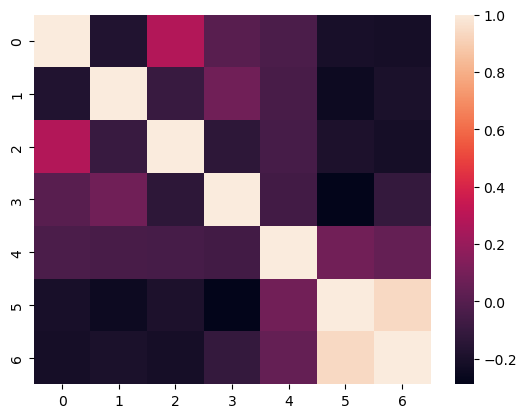

In [208]:
sns.heatmap(CORR)
plt.savefig('../figures/hip_coef_corr.pdf')

In [728]:
mzs = np.load('../processed_data/coronal3d_mz.npy')
adducts = ['M+H','M+Na','M+K']
site_url = 'https://www.lipidmaps.org/rest/moverz/LIPIDS'

annot_df, matched, unmatched = LipidMaps_annotate([621.4834,440.3114,803.5605,931.6396]
, adducts, 5, site_url)

  0%|                                                     | 0/4 [00:00<?, ?it/s]../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
 25%|███████████▎                                 | 1/4 [00:02<00:06,  2.04s/it]../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be 

In [511]:
sc_decode.intens_mtx.columns[[66,  37,  51,  33,   2,  47,  91,   8,  73, 102,  96,  59,  84]]

Index(['651.5337', '473.7511', '586.2119', '441.3297', '403.7882', '566.0302',
       '827.4166', '410.2548', '680.0273', '1088.4539', '931.6396', '617.3433',
       '779.3487'],
      dtype='object')

In [500]:
rank = basis_values[:20].sum(0).argsort()[::-1]
rank

array([ 68,  63,  45,  56,  18,  94,  43,  93,  78,   0,  17, 100,  81,
        66,  37,  51,  33,   2,  47,  91,   8,  73, 102,  96,  59,  84,
        46,  50,  67,  23,  62,  34,   9,  27,  65,  74,  36,  24,  69,
        70,  98,  40,  29,  21,  89,  95,  31,  20,  32,  61,  22,  10,
        30,  79,  72,  88,  49,  26,  90,  53,  86,  99,  92,  57,  28,
        64,  25,  82,  76,   6,  60,  85,  87,  58,  15,  75,  71,  14,
        83,   7,   5,   4,  11,  12,   3,   1,  13,  41,  80,  16,  19,
        42,  55,  54,  52, 101,  48,  44,  35,  97,  38,  77,  39])

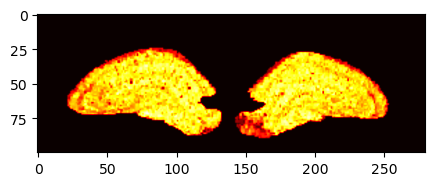

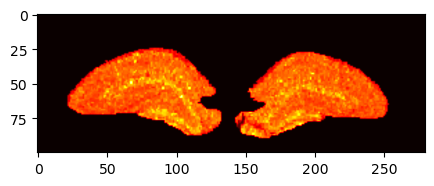

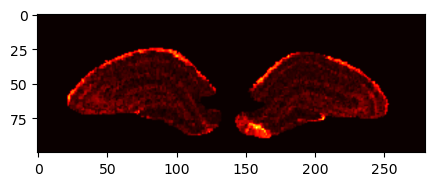

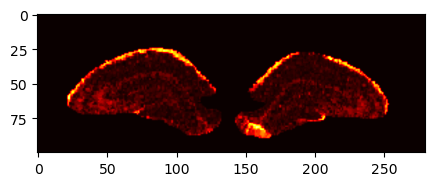

In [514]:
#'621.4834','440.3114','803.5605','931.6396'
for mz in ['437.2496', '803.5605', '440.3114','931.6396']:
    plt.figure(figsize=(5,2))
    plt.imshow(reg.IonImg_transform(tiss_decode.intens_mtx[mz],hip_mask,True),'hot',interpolation='gaussian',
              vmax=1*tiss_decode.intens_mtx[mz].max())
    plt.savefig('../figures/hip_ion_img_{}.pdf'.format(mz))
    plt.show()

In [516]:
mzs = np.load('../processed_data/coronal3d_mz.npy')
adducts = ['M+H','M+Na','M+K']
site_url = 'https://www.lipidmaps.org/rest/moverz/LIPIDS'

annot_df, matched, unmatched = LipidMaps_annotate([437.2496, 803.5605, 440.3114,931.6396]
,adducts, 5, site_url)

  0%|                                                     | 0/4 [00:00<?, ?it/s]../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  rawData = pd.read_csv(io.StringIO(urlData),sep='\t',error_bad_lines=False,index_col=False)
 25%|███████████▎                                 | 1/4 [00:02<00:07,  2.36s/it]../utils.py:140: FutureWarning: The error_bad_lines argument has been deprecated and will be 

In [518]:
annot_df

,Input m/z,Matched m/z,Delta,Name,Formula,Ion
0,437.2496,437.2510,0.0014,ST 22:0;O7,C22H38O7Na,[M+Na]+
1,803.5605,803.5585,0.0020,PA 44:7,C47H80O8P,[M+H]+
2,803.5605,803.5585,0.0020,PA O-44:8;O,C47H80O8P,[M+H]+
3,803.5605,803.5585,0.0020,PEth 42:7,C47H80O8P,[M+H]+
4,803.5605,803.5585,0.0020,DG 49:13,C52H76O5Na,[M+Na]+
5,803.5605,803.5585,0.0020,DG O-49:14;O,C52H76O5Na,[M+Na]+
6,803.5605,803.5585,0.0020,TG O-49:13,C52H76O5Na,[M+Na]+
7,803.5605,803.5644,0.0039,MGDG 36:3,C45H80O10Na,[M+Na]+
8,803.5605,803.5586,0.0019,CE 22:4;O4,C49H80O6K,[M+K]+
9,803.5605,803.5586,0.0019,DG 46:8;O,C49H80O6K,[M+K]+
